run everything with BAN (in MICCAI19-MedVQA):

python3 test.py --model BAN --use_RAD --RAD_dir data_RAD --maml --autoencoder --input saved_models/BAN_MEVF --epoch 19 --output results/BAN_MEVF

In [1]:
import sys
sys.path.append("./MICCAI19-MedVQA")

import argparse
import torch
from torch.utils.data import DataLoader
import dataset_RAD
import base_model
import utils
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from bunch import Bunch

In [2]:
data_RAD = './MICCAI19-MedVQA/data_RAD'
model_path = './MICCAI19-MedVQA/BAN_MEVF'
batch_size = 1
constructor = 'build_BAN'
rnn = 'LSTM'

torch.backends.cudnn.benchmark = True
device = torch.device("cuda")

In [3]:
dictionary = dataset_RAD.Dictionary.load_from_file(os.path.join(data_RAD , 'dictionary.pkl'))

# shitfix so it can work with their code
args = Bunch()
args.RAD_dir = data_RAD
args.autoencoder = True
args.maml = False
args.autoencoder = True
args.feat_dim = 64
args.op = 'c'
args.num_hid = 1024
args.rnn = rnn
args.gamma = 2
args.ae_model_path = 'pretrained_ae.pth'
args.maml_model_path = 'pretrained_maml.weights'
args.activation = 'relu'
args.dropout = 0.5
args.maml = True
args.eps_cnn = 1e-5
args.momentum_cnn = 0.05

# There is a dataset implementation that handles the pipeline (including tokenization and tensor formatting)
eval_dset = dataset_RAD.VQAFeatureDataset('test', args, dictionary)

model = base_model.build_BAN(eval_dset, args)

loading dictionary from ./MICCAI19-MedVQA/data_RAD/dictionary.pkl
loading MAML image data from file: ./MICCAI19-MedVQA/data_RAD/images84x84.pkl
loading DAE image data from file: ./MICCAI19-MedVQA/data_RAD/images128x128.pkl
load initial weights MAML from: ./MICCAI19-MedVQA/data_RAD/pretrained_maml.weights
load initial weights DAE from: ./MICCAI19-MedVQA/data_RAD/pretrained_ae.pth


In [4]:
# Get a dataloader for the dataset
eval_loader = DataLoader(eval_dset, batch_size, shuffle=False, num_workers=0, pin_memory=True, collate_fn=utils.trim_collate)

Each VQA input question is trimmed to a 12-word sentence. The question is zero-padded in case its length is less than 12. Each word is represented by a 600D vector which is a concatenation of the 300D GloVe word embeddings.

The word embeddings is fed into a 1024D LSTM in order to produce the question embeddings [1].

The model contains two convolutional modules - a denoising autoencoder (DAE) and a model-agnostic meta-learning (MAML) algorithm trained with meta-tasks for better representations. More on section 3.1 and 3.2 from [1].

[1]: https://arxiv.org/pdf/1909.11867.pdf

One sample of the dataset object looks like this:

1. The list contains two tensors with the image data - the first one is the flattened MAML image (shape 84 x 84 -> 84 * 84) data and the second one is the flattened DAE image tensor (shape 128 x 128 -> 128 * 128).
2. The second tensor is the tokenized text. (obtained by calling dataset_RAD.VQAFeatureDataset.tokenize())
3. The third tensor is the OHE target of the answer (if the question is closed).
4. Forth tensor is the answer type.
5. Fifth tensor is the question type.
6. Sixth is the phrase type.

More on the questions, answer and phrase type at section 4.1 in [1].

[1]: https://arxiv.org/pdf/1909.11867.pdf

In [5]:
dataloader_sample = next(iter(eval_loader))
dataloader_sample

[[tensor([[0.0275, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
  tensor([[0.0196, 0.0118, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])],
 tensor([[   9,   10,   11,    2,   28,   29,   30, 1177, 1177, 1177, 1177, 1177]]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.

Let's look at the image+question in the sample.

In [6]:
def convert_to_plaintext(dset, sample):
    text = ''
    for token in sample[1][0].numpy():   
        if token == 1177: # pad token
            break
        text += f'{dset.dictionary.idx2word[token]} '
    print(text)
    return text

def show_image(sample):
    plt.imshow(sample[0][1].reshape(128,128).numpy())

is there evidence of an aortic aneurysm 


'is there evidence of an aortic aneurysm '

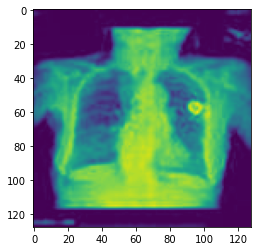

In [7]:
show_image(dataloader_sample)
convert_to_plaintext(eval_dset, dataloader_sample)

Now, let's do inference on this sample

In [8]:
model_path = 'MICCAI19-MedVQA/saved_models/BAN_MEVF/model_epoch19.pth'
model_data = torch.load(model_path)

In [9]:
model = model.to(device)
model.load_state_dict(model_data.get('model_state', model_data))

<All keys matched successfully>

In [10]:
model.train(False)

BAN_Model(
  (w_emb): WordEmbedding(
    (emb): Embedding(1178, 300, padding_idx=1177)
    (emb_): Embedding(1178, 300, padding_idx=1177)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (q_emb): QuestionEmbedding(
    (rnn): LSTM(600, 1024, batch_first=True)
  )
  (v_att): BiAttention(
    (logits): BCNet(
      (v_net): FCNet(
        (main): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Linear(in_features=128, out_features=3072, bias=True)
          (2): ReLU()
        )
      )
      (q_net): FCNet(
        (main): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Linear(in_features=1024, out_features=3072, bias=True)
          (2): ReLU()
        )
      )
      (dropout): Dropout(p=0.5, inplace=False)
      (p_net): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
    )
  )
  (b_net): ModuleList(
    (0): BCNet(
      (v_net): FCNet(
        (main): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Line

In [11]:
v, q, a, ans_type, q_types, p_type = dataloader_sample

In [12]:
# Add channel
v[0] = v[0].reshape(v[0].shape[0], 84, 84).unsqueeze(1).to(device)   # MAML
v[1] = v[1].reshape(v[1].shape[0], 128, 128).unsqueeze(1).to(device) # Autoencoder

q = q.to(device)
a = a.to(device)

features, _ = model(v, q)

In [13]:
logits = model.classifier(features)
prediction = torch.max(logits, 1)[1].data #argmax

... and get the result using dataset.label2ans

In [14]:
eval_dset.label2ans[prediction.item()]

'no'

MISC:

The test image data is in the ae_image_data attribute. Let's look at a sample:

In [15]:
eval_dset.ae_images_data.shape

torch.Size([315, 128, 128, 1])

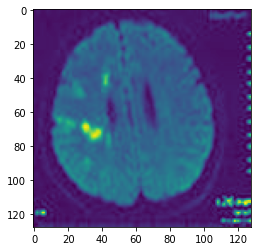

In [16]:
plt.imshow(eval_dset.ae_images_data[0].squeeze(2).numpy())